In [ ]:
import sys
import glob
import progressbar
from os import listdir
from os import path
import os
import shutil
from matplotlib.image import imread
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
 
root_dir_path = '/content/drive/MyDrive/DATASET/Labelled'
 
 
def load_data(root_dir_name):
  img_paths = []
  labels = []
  class_names = listdir(root_dir_name)
  for class_name in class_names:
    class_path = path.join(root_dir_name, class_name)
    img_names = listdir(f"{root_dir_name}/{class_name}")
    for img_name in img_names:
      img_path = path.join(root_dir_name, class_name, img_name)
      if img_path.endswith(".jpg") == True or img_path.endswith(".JPG") == True:
        img_paths.append(img_path)
        labels.append(class_name)
  return img_paths, labels
 
 
def convert_label_string_to_num(labels):
  encoder = LabelEncoder()
  return encoder.fit_transform(labels), encoder  
 
def split_data(img_paths, labels):
  x_train, x_test, y_train, y_test = train_test_split(img_paths, 
                                                      labels, 
                                                      test_size=0.22, 
                                                      random_state = 10, 
                                                      stratify=labels)
  return x_train, x_test, y_train, y_test 
 
img_paths, labels = load_data(root_dir_path)
img_paths, labels = shuffle(img_paths, labels, random_state=22)
labels, encoder = convert_label_string_to_num(labels)
x_train_paths, x_valid_paths, labels_train, labels_valid  = split_data(img_paths, labels)

In [ ]:
import tensorflow as tf
from matplotlib.image import imread
 
NEW_IMG_SIZE = 650
TRAIN_BATCH_SIZE = 20
VAL_BATCH_SIZE = 10
 
def get_img(img_path, label):
  img_array = tf.io.read_file(img_path)
  img_array = tf.image.decode_jpeg(img_array, channels=3)
  img_array = tf.cast(img_array, tf.float32)
  img_array = tf.image.resize_with_pad(img_array, NEW_IMG_SIZE, NEW_IMG_SIZE, 
                                      method=tf.image.ResizeMethod.AREA)
  return img_array, label
 
def build_data(x_paths, labels, mode):
  ds = (tf.data.Dataset.from_tensor_slices((x_paths, labels)) 
                      .shuffle(buffer_size=4000) 
                      .map(get_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .map(lambda x, y: (tf.math.divide(x, 255.0), y)) 
  )
 
  if mode=='train':
    return ds.repeat(None).batch(TRAIN_BATCH_SIZE).prefetch(1)
  ds = (ds.map(lambda a, b: (a, b)) 
        .batch(batch_size=VAL_BATCH_SIZE) 
        .prefetch(tf.data.experimental.AUTOTUNE)
  )
  return ds
 
train_ds = build_data(x_train_paths, labels_train, mode='train')
valid_ds = build_data(x_valid_paths, labels_valid, mode='validation')

In [ ]:
from keras.applications.densenet import DenseNet201
#%load_ext tensorboard
import datetime, os
from keras import backend as K

 
width=650
height=650
depth=3
LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = len(encoder.classes_)
TRAIN_LENGTH = len(x_train_paths)

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



inputs = tf.keras.Input(shape=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3))
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[NEW_IMG_SIZE,NEW_IMG_SIZE,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])
out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = inception_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='inception_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization(axis=chanDim)(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization(axis=chanDim)(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/dense.h5", verbose=1,
                                                save_best_only=True)
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=3, verbose=1)
 
#%tensorboard --logdir logs
history = model.fit(train_ds, callbacks=[reduce_callback, checkpoint],
          validation_data=valid_ds,
          steps_per_epoch=TRAIN_LENGTH // TRAIN_BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1)

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 1.2768 - accuracy: 0.5477
Epoch 1: val_loss improved from inf to 2.50148, saving model to /content/drive/MyDrive/dense.h5
130/130 [==============================] - 955s 7s/step - loss: 1.2768 - accuracy: 0.5477 - val_loss: 2.5015 - val_accuracy: 0.3126 - lr: 0.0010
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.7154
Epoch 2: val_loss improved from 2.50148 to 0.73134, saving model to /content/drive/MyDrive/dense.h5
130/130 [==============================] - 442s 3s/step - loss: 0.8440 - accuracy: 0.7154 - val_loss: 0.7313 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 3/30
130/130 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7562
Epoch 3: val_loss did not improve from 0.73134
130/130 [==============================] - 439s 3s/step - loss: 0.6962 - accuracy: 0.7562 - val_loss: 1.3426 - val

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/dense.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(valid_ds)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
74/74 [==============================] - 1430s 19s/step - loss: 0.4007 - accuracy: 0.8674
Test Accuracy: 86.7388367652893


In [ ]:
#x_train_paths, x_valid_paths, labels_train, labels_valid
from sklearn import metrics
from sklearn import preprocessing 
import numpy as np
#x_test = np.argmax(x_valid_paths, axis=1)
#y_test=np.argmax(labels_valid,axis=1)
y_pred=np.argmax(model.predict(valid_ds),axis=1)
print(metrics.confusion_matrix(labels_valid,y_pred)) 
print("\n")
# print("---------------------Classification report-----------------------")
# print(metrics.classification_report(model.evaluate(valid_ds)))
# print("\n")
# print("---------------------Area under ROC Curve------------------------")
# print(metrics.roc_auc_score(model.evaluate(valid_ds)))

[[ 14  56  19  26]
 [ 44 152  49  83]
 [ 18  48  21  37]
 [ 31  82  26  33]]




In [ ]:
print("---------------------Classification report-----------------------")
print(metrics.classification_report(labels_valid,y_pred))

---------------------Classification report-----------------------
              precision    recall  f1-score   support

           0       0.13      0.12      0.13       115
           1       0.45      0.46      0.46       328
           2       0.18      0.17      0.18       124
           3       0.18      0.19      0.19       172

    accuracy                           0.30       739
   macro avg       0.24      0.24      0.24       739
weighted avg       0.29      0.30      0.30       739



In [ ]:
print("---------------------Area under ROC Curve------------------------")
print(metrics.roc_auc_score(labels_valid,y_pred,multi_class="ovr",average="macro"))

---------------------Area under ROC Curve------------------------


AxisError: ignored

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels_valid, model.predict_on_batch(valid_ds)[:,1])

# Calculate Area under the curve to display on the plot
auc = metrics.roc_auc_score(labels_valid,y_pred)

# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('Densenet_201', auc))

AttributeError: ignored

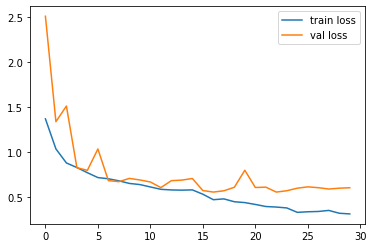

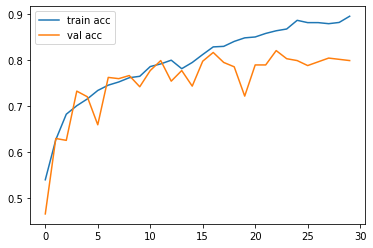

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/checkpoint.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(valid_ds)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
74/74 [==============================] - 1235s 16s/step - loss: 0.2778 - accuracy: 0.8972
Test Accuracy: 89.71583247184753


In [ ]:
#x_train_paths, x_valid_paths, labels_train, labels_valid
from sklearn import metrics
from sklearn import preprocessing 
import numpy as np
#x_test = np.argmax(x_valid_paths, axis=1)
#y_test=np.argmax(labels_valid,axis=1)
y_pred=np.argmax(model.predict(valid_ds),axis=1)
print(metrics.confusion_matrix(labels_valid,y_pred)) 
print("\n")

[[ 13  61  17  24]
 [ 39 158  52  79]
 [ 18  60  22  24]
 [ 40  78  24  30]]




In [ ]:
print("---------------------Classification report-----------------------")
print(metrics.classification_report(labels_valid,y_pred))

---------------------Classification report-----------------------
              precision    recall  f1-score   support

           0       0.12      0.11      0.12       115
           1       0.44      0.48      0.46       328
           2       0.19      0.18      0.18       124
           3       0.19      0.17      0.18       172

    accuracy                           0.30       739
   macro avg       0.24      0.24      0.24       739
weighted avg       0.29      0.30      0.30       739



In [ ]:
#x_test=np.argmax(x_valid_paths,axis=1)
from sklearn import metrics
y_pred=np.argmax(model.predict(valid_ds),axis=1)

print("---------------------Classification report-----------------------")
print(metrics.classification_report(valid_ds,y_pred))

---------------------Classification report-----------------------


ValueError: ignored

In [ ]:
print("Test Accuracy", metrics.accuracy_score(valid_ds, model.predict(valid_ds)))


KeyboardInterrupt: ignored